### 정수형 레이블 pt 텐서(폴리건 포인트)

In [9]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_1_final_metadata.json'
original_image_folder = './Surface_1'
output_tensor_folder = './Surface_1_tensors_256x256'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 1,      # 점자 블록
    "roadway": 2,                   # 도로
    "alley": 2,                     # 골목길
    "caution_zone": 2,              # 위험 구역
    "crosswalk": 3,                 # 횡단보도
    "bike_lane": 4,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_1_final_metadata.json
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000001_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000002_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000003_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000004_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000005_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000006_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000007_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000008_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000009_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000010_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000011_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000012_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000013_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256/MP_SEL_SUR_000014_mask.pt
[완료] 텐서 저장: ./S

In [10]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_2_final_metadata.json'
original_image_folder = './Surface_2'
output_tensor_folder = './Surface_2_tensors_256x256'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 1,      # 점자 블록
    "roadway": 2,                   # 도로
    "alley": 2,                     # 골목길
    "caution_zone": 2,              # 위험 구역
    "crosswalk": 3,                 # 횡단보도
    "bike_lane": 4,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_2_final_metadata.json
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009881_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009882_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009883_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009884_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009885_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009886_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009887_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009888_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009889_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009890_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009891_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009892_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009893_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256/MP_SEL_SUR_009894_mask.pt
[완료] 텐서 저장: ./S

In [11]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_3_final_metadata.json'
original_image_folder = './Surface_3'
output_tensor_folder = './Surface_3_tensors_256x256'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 1,      # 점자 블록
    "roadway": 2,                   # 도로
    "alley": 2,                     # 골목길
    "caution_zone": 2,              # 위험 구역
    "crosswalk": 3,                 # 횡단보도
    "bike_lane": 4,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_3_final_metadata.json
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021379_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021380_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021381_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021382_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021383_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021384_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021385_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021386_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021387_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021388_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021389_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021390_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021391_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256/MP_SEL_SUR_021392_mask.pt
[완료] 텐서 저장: ./S

In [12]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_4_final_metadata.json'
original_image_folder = './Surface_4'
output_tensor_folder = './Surface_4_tensors_256x256'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 1,      # 점자 블록
    "roadway": 2,                   # 도로
    "alley": 2,                     # 골목길
    "caution_zone": 2,              # 위험 구역
    "crosswalk": 3,                 # 횡단보도
    "bike_lane": 4,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_4_final_metadata.json
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030209_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030210_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030211_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030212_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030213_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030214_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030215_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030216_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030217_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030218_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030219_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030220_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030221_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256/MP_SEL_SUR_030222_mask.pt
[완료] 텐서 저장: ./S

In [13]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_5_final_metadata.json'
original_image_folder = './Surface_5'
output_tensor_folder = './Surface_5_tensors_256x256'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 1,      # 점자 블록
    "roadway": 2,                   # 도로
    "alley": 2,                     # 골목길
    "caution_zone": 2,              # 위험 구역
    "crosswalk": 3,                 # 횡단보도
    "bike_lane": 4,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_5_final_metadata.json
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035322_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035323_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035324_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035325_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035326_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035327_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035328_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035329_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035330_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035331_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035332_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035333_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035334_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256/MP_SEL_SUR_035335_mask.pt
[완료] 텐서 저장: ./S

### 시각화

[확인] 총 9558개의 텐서 파일이 발견되었습니다.
[로딩] 텐서 파일: MP_SEL_SUR_006285_mask.pt | 크기: (256, 256)
[로딩] 원본 이미지: ./Surface_1/MP_SEL_SUR_006285.jpg | 원본 크기: (1080, 1920, 3)
[변환] 리사이즈된 이미지 크기: (256, 256, 3)


/tmp/ipykernel_454282/3196519690.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  label_tensor = torch.load(tensor_path).numpy()  # [256, 256]


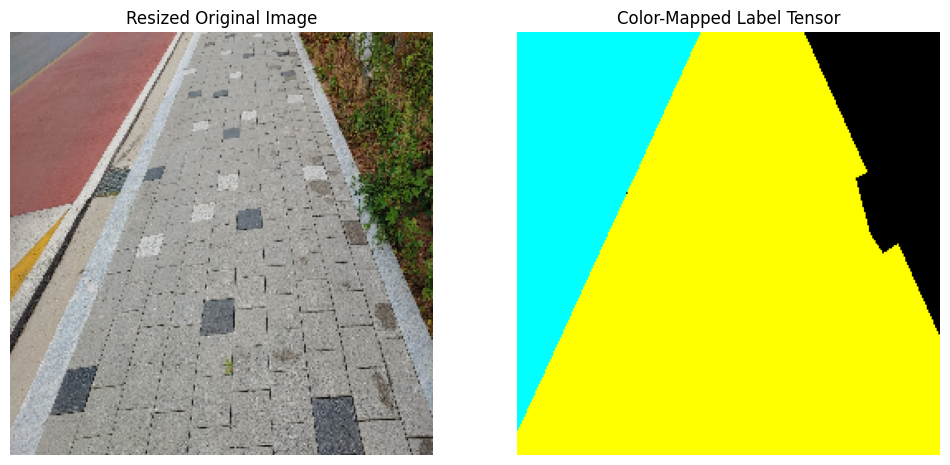

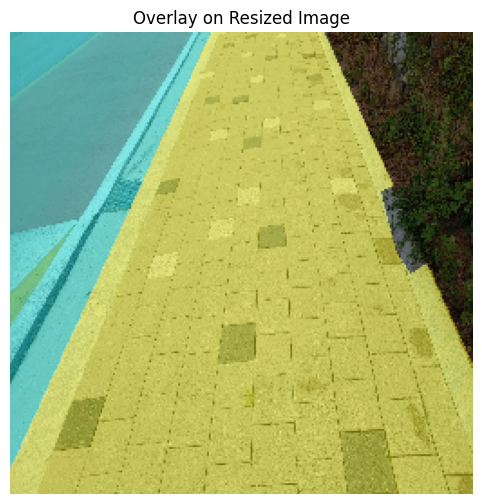

In [21]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 저장된 텐서 파일 경로 설정
output_tensor_folder = './Surface_1_tensors_256x256'
original_image_folder = './Surface_1'

# 클래스 ID별 색상 지정 (BGR 포맷, OpenCV에서 사용)
class_colors = {
    1: [0, 255, 255],   # 노란색 (인도+점자블록)
    2: [255, 255, 0],   # 하늘색 (도로+골목길+위험구역)
    3: [128, 0, 0],     # 남색 (횡단보도)
    4: [0, 255, 0]      # 초록색 (자전거도로)
}

# 파일 목록 확인
tensor_files = [f for f in os.listdir(output_tensor_folder) if f.endswith('.pt')]
print(f"[확인] 총 {len(tensor_files)}개의 텐서 파일이 발견되었습니다.")

# 첫 번째 텐서 파일과 해당 원본 이미지 불러오기
if tensor_files:
    tensor_filename = tensor_files[0]
    tensor_path = os.path.join(output_tensor_folder, tensor_filename)
    image_name = tensor_filename.replace('_mask.pt', '.jpg')  # 원본 이미지 이름 추정
    image_path = os.path.join(original_image_folder, image_name)

    # 텐서 로드
    label_tensor = torch.load(tensor_path).numpy()  # [256, 256]
    print(f"[로딩] 텐서 파일: {tensor_filename} | 크기: {label_tensor.shape}")

    # 원본 이미지 로드 및 256x256으로 리사이즈
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"[경고] 원본 이미지를 찾을 수 없습니다: {image_path}")
    else:
        print(f"[로딩] 원본 이미지: {image_path} | 원본 크기: {original_image.shape}")

        resized_image = cv2.resize(original_image, (256, 256))  # 256x256으로 리사이즈
        print(f"[변환] 리사이즈된 이미지 크기: {resized_image.shape}")

        # 텐서를 색상 맵으로 변환
        color_mapped_tensor = np.zeros((*label_tensor.shape, 3), dtype=np.uint8)  # (256, 256, 3)
        for class_id, color in class_colors.items():
            color_mapped_tensor[label_tensor == class_id] = color  # 클래스 ID에 해당하는 색상 적용

        # 시각화
        plt.figure(figsize=(12, 6))

        # 원본 이미지 (리사이즈된)
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        plt.title("Resized Original Image")
        plt.axis("off")

        # 색상이 적용된 텐서 시각화
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(color_mapped_tensor, cv2.COLOR_BGR2RGB))
        plt.title("Color-Mapped Label Tensor")
        plt.axis("off")

        plt.show()

        # 원본 이미지에 텐서 오버레이
        overlay = cv2.addWeighted(resized_image, 0.6, color_mapped_tensor, 0.4, 0)
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title("Overlay on Resized Image")
        plt.axis("off")
        plt.show()
else:
    print("[오류] 텐서 파일이 존재하지 않습니다.")


In [18]:
import os

folder_path = '/home/dongju/캡스톤디자인2/Surface_1'
files = os.listdir(folder_path)
print("[확인] Surface_1 폴더 내 파일 목록:")
for f in files:
    print(f)


[확인] Surface_1 폴더 내 파일 목록:
MP_SEL_SUR_001610.jpg
MP_SEL_SUR_009316.jpg
MP_SEL_SUR_000730.jpg
MP_SEL_SUR_005545.jpg
MP_SEL_SUR_006961.jpg
MP_SEL_SUR_003369.jpg
MP_SEL_SUR_007434.jpg
MP_SEL_SUR_001447.jpg
MP_SEL_SUR_003839.jpg
MP_SEL_SUR_009151.jpg
MP_SEL_SUR_002429.jpg
MP_SEL_SUR_008211.jpg
MP_SEL_SUR_001724.jpg
MP_SEL_SUR_008374.jpg
MP_SEL_SUR_001215.jpg
MP_SEL_SUR_006682.jpg
MP_SEL_SUR_003326.jpg
MP_SEL_SUR_002173.jpg
MP_SEL_SUR_007412.jpg
MP_SEL_SUR_002446.jpg
MP_SEL_SUR_001578.jpg
MP_SEL_SUR_000319.jpg
MP_SEL_SUR_006561.jpg
MP_SEL_SUR_002720.jpg
MP_SEL_SUR_003518.jpg
MP_SEL_SUR_004683.jpg
MP_SEL_SUR_008047.jpg
MP_SEL_SUR_007948.jpg
MP_SEL_SUR_004555.jpg
MP_SEL_SUR_005211.jpg
MP_SEL_SUR_005572.jpg
MP_SEL_SUR_001212.jpg
MP_SEL_SUR_001865.jpg
MP_SEL_SUR_009112.jpg
MP_SEL_SUR_005693.jpg
MP_SEL_SUR_006380.jpg
MP_SEL_SUR_007048.jpg
MP_SEL_SUR_001420.jpg
MP_SEL_SUR_007811.jpg
MP_SEL_SUR_001389.jpg
MP_SEL_SUR_005930.jpg
MP_SEL_SUR_001680.jpg
MP_SEL_SUR_007557.jpg
MP_SEL_SUR_001400.jpg
MP_SE

/tmp/ipykernel_857264/2384479795.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  label_tensor = torch.load(tensor_path).numpy()  # [256, 256]


[로딩] 텐서 파일: MP_SEL_SUR_003512_mask.pt | 크기: (256, 256)


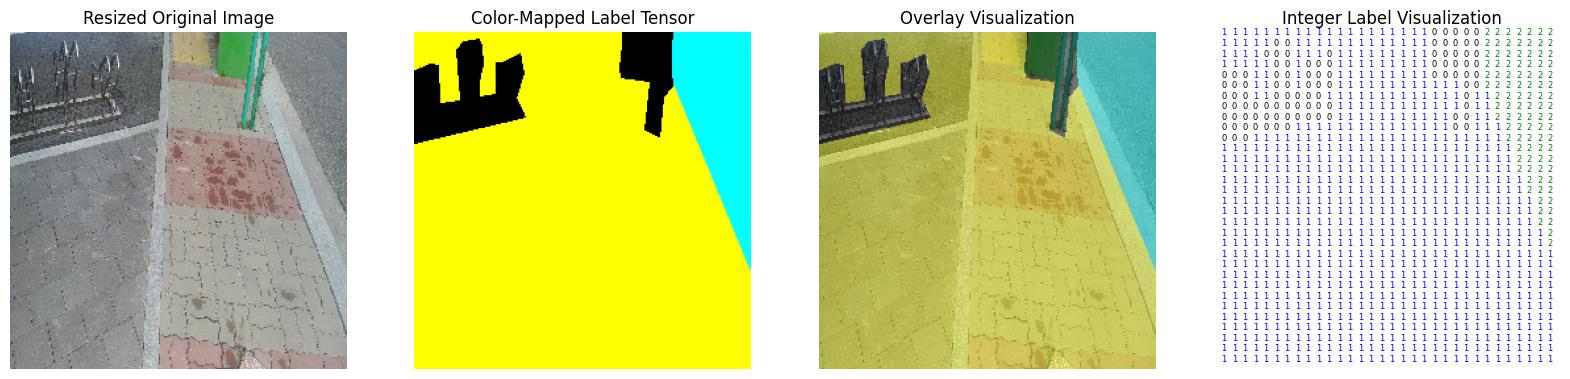

In [14]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


# 저장된 텐서 파일 경로 설정
output_tensor_folder = './Surface_1_tensors_256x256'
original_image_folder = './Surface_1'

# 클래스 ID별 색상 지정 (BGR 포맷, OpenCV에서 사용)
class_colors = {
    1: [0, 255, 255],   # 노란색 (인도+점자블록)
    2: [255, 255, 0],   # 하늘색 (도로+골목길+위험구역)
    3: [128, 0, 0],     # 남색 (횡단보도)
    4: [0, 255, 0]      # 초록색 (자전거도로)
}

# 정수형 레이블을 텍스트로 시각화 (배경 흰색, 숫자별 색상)
def plot_label_text_with_colors(label_tensor):
    """
    정수형 라벨 배열을 텍스트 형태로 시각화 (배경 흰색, 숫자별 색상 적용)
    
    Args:
        label_tensor (np.ndarray): [H, W] 형태의 라벨 텐서
    """
    label_array = label_tensor  # 이미 numpy 배열 형태로 전달됨
    h, w = label_array.shape

    # 숫자별 색상 설정
    number_colors = {
        0: 'black',   # 배경
        1: 'blue',    # 클래스 1
        2: 'green',   # 클래스 2
        3: 'red',     # 클래스 3
        4: 'purple',  # 클래스 4
    }

    # 흰색 배경 생성
    white_background = np.ones((h, w, 3), dtype=np.uint8) * 255  # 흰색 (RGB: 255, 255, 255)
    plt.imshow(white_background)  # 흰색 배경을 먼저 표시
    for i in range(0, h, 8):  # 8픽셀 간격으로 텍스트 표시
        for j in range(0, w, 8):  # 8픽셀 간격으로 텍스트 표시
            value = label_array[i, j]
            color = number_colors.get(value, 'black')  # 숫자별 색상 선택
            plt.text(j, i, str(value), fontsize=6, ha='center', va='center', color=color)
    plt.axis('off')

def visualize_segmentation_with_overlay(image_tensor, label_tensor):
    """
    정수형 라벨을 숫자로 보여주는 시각화 + 원본 이미지 + Overlay 추가
    
    Args:
        image_tensor (np.ndarray): [H, W, 3] 형태의 입력 이미지 배열
        label_tensor (np.ndarray): [H, W] 형태의 정수형 라벨 배열
    """
    # 색상 매핑된 텐서 생성
    color_mapped_tensor = np.zeros((*label_tensor.shape, 3), dtype=np.uint8)  # (H, W, 3)
    for class_id, color in class_colors.items():
        color_mapped_tensor[label_tensor == class_id] = color

    # Overlay 생성
    overlay = cv2.addWeighted(image_tensor, 0.6, color_mapped_tensor, 0.4, 0)

    # 시각화
    plt.figure(figsize=(20, 6))  # 4개의 subplot 추가
    # 원본 이미지
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image_tensor, cv2.COLOR_BGR2RGB))
    plt.title("Resized Original Image")
    plt.axis("off")

    # 색상 매핑된 레이블 텐서
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(color_mapped_tensor, cv2.COLOR_BGR2RGB))
    plt.title("Color-Mapped Label Tensor")
    plt.axis("off")

    # Overlay된 이미지
    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Overlay Visualization")
    plt.axis("off")

    # 정수형 레이블 텍스트 시각화
    plt.subplot(1, 4, 4)
    plot_label_text_with_colors(label_tensor)
    plt.title("Integer Label Visualization")
    plt.axis("off")

    plt.show()


# 텐서 파일 목록 불러오기
tensor_files = [f for f in os.listdir(output_tensor_folder) if f.endswith('_mask.pt')]

# 테스트
if tensor_files:
    # 랜덤으로 텐서 파일 선택
    tensor_filename = random.choice(tensor_files)
    tensor_path = os.path.join(output_tensor_folder, tensor_filename)
    image_name = tensor_filename.replace('_mask.pt', '.jpg')  # 원본 이미지 이름 추정
    image_path = os.path.join(original_image_folder, image_name)

    # 텐서 로드
    label_tensor = torch.load(tensor_path).numpy()  # [256, 256]
    print(f"[로딩] 텐서 파일: {tensor_filename} | 크기: {label_tensor.shape}")

    # 원본 이미지 로드 및 256x256으로 리사이즈
    original_image = cv2.imread(image_path)
    resized_image = cv2.resize(original_image, (256, 256))  # 256x256으로 리사이즈

    # 시각화 호출
    visualize_segmentation_with_overlay(resized_image, label_tensor)
else:
    print("텐서 파일이 폴더에 없습니다.")


In [1]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_1_final_metadata.json'
original_image_folder = './Surface_1'
output_tensor_folder = './Surface_1_tensors_256x256(7 classes)'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 2,      # 점자 블록
    "roadway": 3,                   # 도로
    "alley": 4,                     # 골목길
    "caution_zone": 5,              # 위험 구역
    "crosswalk": 6,                 # 횡단보도
    "bike_lane": 7,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_1_final_metadata.json
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000001_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000002_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000003_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000004_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000005_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000006_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000007_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000008_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000009_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000010_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000011_mask.pt
[완료] 텐서 저장: ./Surface_1_tensors_256x256(7 classes)/MP_SEL_SUR_000012_mask.pt
[완료] 텐서 저장: ./S

In [2]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_2_final_metadata.json'
original_image_folder = './Surface_2'
output_tensor_folder = './Surface_2_tensors_256x256(7 classes)'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 2,      # 점자 블록
    "roadway": 3,                   # 도로
    "alley": 4,                     # 골목길
    "caution_zone": 5,              # 위험 구역
    "crosswalk": 6,                 # 횡단보도
    "bike_lane": 7,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_2_final_metadata.json
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009881_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009882_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009883_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009884_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009885_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009886_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009887_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009888_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009889_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009890_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009891_mask.pt
[완료] 텐서 저장: ./Surface_2_tensors_256x256(7 classes)/MP_SEL_SUR_009892_mask.pt
[완료] 텐서 저장: ./S

In [3]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_3_final_metadata.json'
original_image_folder = './Surface_3'
output_tensor_folder = './Surface_3_tensors_256x256(7 classes)'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 2,      # 점자 블록
    "roadway": 3,                   # 도로
    "alley": 4,                     # 골목길
    "caution_zone": 5,              # 위험 구역
    "crosswalk": 6,                 # 횡단보도
    "bike_lane": 7,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_3_final_metadata.json
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021379_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021380_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021381_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021382_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021383_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021384_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021385_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021386_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021387_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021388_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021389_mask.pt
[완료] 텐서 저장: ./Surface_3_tensors_256x256(7 classes)/MP_SEL_SUR_021390_mask.pt
[완료] 텐서 저장: ./S

In [4]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_4_final_metadata.json'
original_image_folder = './Surface_4'
output_tensor_folder = './Surface_4_tensors_256x256(7 classes)'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 2,      # 점자 블록
    "roadway": 3,                   # 도로
    "alley": 4,                     # 골목길
    "caution_zone": 5,              # 위험 구역
    "crosswalk": 6,                 # 횡단보도
    "bike_lane": 7,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_4_final_metadata.json
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030209_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030210_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030211_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030212_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030213_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030214_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030215_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030216_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030217_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030218_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030219_mask.pt
[완료] 텐서 저장: ./Surface_4_tensors_256x256(7 classes)/MP_SEL_SUR_030220_mask.pt
[완료] 텐서 저장: ./S

In [5]:
import os
import json
import numpy as np
import cv2
import torch

# JSON 파일 경로 및 폴더 설정
json_path = './metadata/Surface_5_final_metadata.json'
original_image_folder = './Surface_5'
output_tensor_folder = './Surface_5_tensors_256x256(7 classes)'
os.makedirs(output_tensor_folder, exist_ok=True)

# 새로운 클래스 매핑
label_to_new_id = {
    "sidewalk": 1,                  # 인도
    "braille_guide_blocks": 2,      # 점자 블록
    "roadway": 3,                   # 도로
    "alley": 4,                     # 골목길
    "caution_zone": 5,              # 위험 구역
    "crosswalk": 6,                 # 횡단보도
    "bike_lane": 7,                 # 자전거도로
}

# 폴리곤 좌표를 리사이즈 크기로 변환
def resize_polygon_points(points, original_size, target_size):
    """
    폴리곤 좌표를 리사이즈된 이미지 크기에 맞게 변환합니다.
    """
    orig_h, orig_w = original_size
    target_h, target_w = target_size
    try:
        return [[int(x * target_w / orig_w), int(y * target_h / orig_h)] for x, y in points]
    except Exception as e:
        print(f"[오류] 폴리곤 좌표 변환 실패: {points} | {e}")
        return []

# 정수형 레이블 텐서 생성 함수
def create_resized_label_tensor(image_size, polygons, label_to_new_id):
    """
    리사이즈된 크기의 정수형 레이블 텐서를 생성합니다.
    """
    height, width = image_size
    label_tensor = np.zeros((height, width), dtype=np.uint8)  # 초기화: 0 (Background)

    for polygon in polygons:
        label = polygon.get('label')
        attribute = polygon.get('attribute', None)
        new_class_id = label_to_new_id.get(label, 0)

        if attribute == "crosswalk":
            new_class_id = label_to_new_id.get("crosswalk", 0)

        if new_class_id > 0:
            points = np.array(polygon['points'], dtype=np.int32)
            try:
                cv2.fillPoly(label_tensor, [points], new_class_id)
            except Exception as e:
                print(f"[오류] 폴리곤 그리기 실패: {polygon} | {e}")

    return torch.tensor(label_tensor, dtype=torch.uint8)

# JSON 파일 열기
try:
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        print(f"[완료] JSON 파일 로드 성공: {json_path}")
except FileNotFoundError:
    print(f"[오류] JSON 파일을 찾을 수 없습니다: {json_path}")
    metadata = []

# 텐서 생성 및 저장
target_size = (256, 256)  # 학습에 사용할 크기
for image_data in metadata:
    try:
        image_name = image_data.get('image_name')
        polygons = image_data.get('polygons', [])

        if not image_name:
            print(f"[오류] 'image_name' 필드가 없습니다: {image_data}")
            continue

        image_path = os.path.join(original_image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"[경고] 이미지를 찾을 수 없습니다: {image_path}")
            continue

        # 원본 이미지 불러오기
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"[경고] 이미지 로드 실패: {image_path}")
            continue
        original_size = original_image.shape[:2]  # (height, width)

        # 폴리곤 좌표 리사이즈
        resized_polygons = [
            {
                "label": polygon["label"],
                "points": resize_polygon_points(polygon["points"], original_size, target_size),
                "attribute": polygon.get("attribute")
            }
            for polygon in polygons
        ]

        # 정수형 레이블 텐서 생성
        resized_label_tensor = create_resized_label_tensor(target_size, resized_polygons, label_to_new_id)

        # 텐서 저장
        tensor_filename = os.path.join(output_tensor_folder, f"{os.path.splitext(image_name)[0]}_mask.pt")
        torch.save(resized_label_tensor, tensor_filename)
        print(f"[완료] 텐서 저장: {tensor_filename}")

    except KeyError as e:
        print(f"[오류] JSON 데이터 누락: {e} | 데이터: {image_data}")
    except Exception as e:
        print(f"[오류] 처리 실패: {e}")


[완료] JSON 파일 로드 성공: ./metadata/Surface_5_final_metadata.json
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035322_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035323_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035324_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035325_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035326_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035327_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035328_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035329_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035330_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035331_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035332_mask.pt
[완료] 텐서 저장: ./Surface_5_tensors_256x256(7 classes)/MP_SEL_SUR_035333_mask.pt
[완료] 텐서 저장: ./S